# Figures S5 and S7 and S10









In [55]:

from scipy.integrate import odeint, solve_ivp, lsoda
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from lmfit import Parameters, minimize, Model, report_fit, conf_interval
from sklearn.metrics import mean_squared_error
import numdifftools
from PIL import Image
from sklearn.metrics import r2_score
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



import scipy.optimize
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as tkr
import scipy.stats as st
from scipy.stats import scoreatpercentile



import glob


# Asthetics

In [56]:
colors = [  "#56B4E9", "#009E73", "#CC79A7", "#999999", "#E69F00","#DB2B39", "#0076A1", "#0072B2", "#1A5042","#0C1713"]
palette = sns.color_palette(colors)

sns.set_theme(context='notebook', style='ticks', font='Arial', 
              font_scale=1, 
              rc={"lines.linewidth": 1, 'axes.linewidth':1, 
                                  "xtick.major.width":1,"ytick.major.width":1}, 
              palette = palette)
sns.color_palette(colors)

[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.6, 0.6, 0.6),
 (0.9019607843137255, 0.6235294117647059, 0.0),
 (0.8588235294117647, 0.16862745098039217, 0.2235294117647059),
 (0.0, 0.4627450980392157, 0.6313725490196078),
 (0.0, 0.4470588235294118, 0.6980392156862745),
 (0.10196078431372549, 0.3137254901960784, 0.25882352941176473),
 (0.047058823529411764, 0.09019607843137255, 0.07450980392156863)]

## Kinetics of the click reaction with two different azides and different conditions (with and without droplets)


In [57]:
df = pd.read_excel("Active_Kinetics.xlsx")
df["C"] = df["Azide_1"] + "-" + df["Azide_2"]+ "-" + df["Type"]
df

,Time,Azide1,Azide2,cal1,cal2,mM_Azide1,mM_Azide2,Azide_1,Azide_2,Type,Ref,Yield1,Yield2,Total_yield,C
0,0,NaN,NaN,5.56,4.29,3.200000,3.200000,Gly,kArg,no_pSS,HS-D-87,0.000000,0.000000,0.000000,Gly-kArg-no_pSS
1,1,17.7206,12.4418,5.56,4.29,3.187158,2.900186,Gly,kArg,no_pSS,HS-D-87,0.401304,9.369172,9.770476,Gly-kArg-no_pSS
2,2,15.2370,10.6746,5.56,4.29,2.740468,2.488252,Gly,kArg,no_pSS,HS-D-87,14.360387,22.242133,36.602520,Gly-kArg-no_pSS
3,4,10.6342,7.2056,5.56,4.29,1.912626,1.679627,Gly,kArg,no_pSS,HS-D-87,40.230441,47.511655,87.742096,Gly-kArg-no_pSS
4,8,10.5815,6.9970,5.56,4.29,1.903147,1.631002,Gly,kArg,no_pSS,HS-D-87,40.526641,49.031177,89.557818,Gly-kArg-no_pSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,21.0000,11.8000,6.72,3.66,3.125000,3.224044,Cys,kArg,no_pSS,HS-D-93,2.976190,-0.954116,2.022075,Cys-kArg-no_pSS
188,2,17.2476,9.5672,6.72,3.66,2.566607,2.613989,Cys,kArg,no_pSS,HS-D-93,25.134637,23.254402,48.389039,Cys-kArg-no_pSS
189,4,14.4253,8.0605,6.72,3.66,2.146622,2.202322,Cys,kArg,no_pSS,HS-D-93,41.800713,39.590381,81.391094,Cys-kArg-no_pSS
190,8,13.4973,7.3779,6.72,3.66,2.008527,2.015820,Cys,kArg,no_pSS,HS-D-93,47.280683,46.991283,94.271966,Cys-kArg-no_pSS


In [58]:
df[["Type", "Azide_1", "Azide_2", "Time", "Yield1", "Yield2", "C"]].to_csv("Kinetics.csv", index=False)


In [59]:
def monoexponential(x, A, k, B):
    """
    Compute the value of a monoexponential function at point x.
    
    Args:
        x (float): The input value.
        A (float): Amplitude or initial value.
        k (float): Decay constant or growth rate.
    
    Returns:
        float: The value of the monoexponential function at point x.
    """
    return B + (A * np.exp(-k * x))

def fit_monoexponential_two_Azides_Yield(df):
    t = df["Time"].values
    azide1 = df["Yield1"].values
    azide2 = df["Yield2"].values

    # Fit data to monoexponential function
    popt1, pcov1 = curve_fit(monoexponential, t, azide1, p0=[100, 0.5, azide1[-2:].mean()])
    popt2, pcov2 = curve_fit(monoexponential, t, azide2, p0=[100, 0.5, azide2[-2:].mean()])

    # Calculate uncertainties
    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))

    return pd.DataFrame({"Azide1": popt1, "Azide1_err": perr1, "Azide2": popt2, "Azide2_err": perr2}, index=["A", "k", "B"])




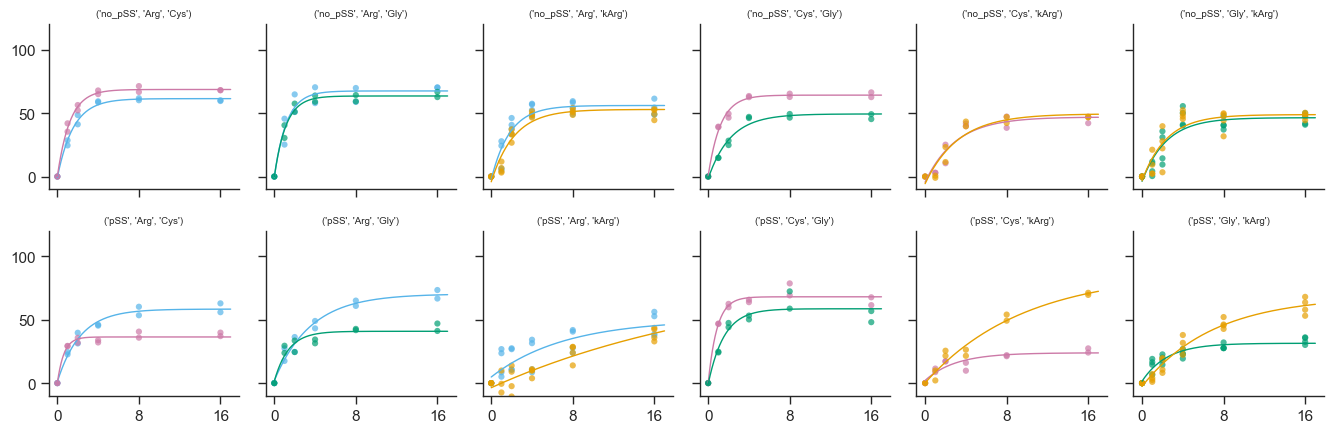

In [60]:
fits = []
df["Replica"] = sorted(["A", "B"] * 6) * 16

colors = (["C0", "C2"], ["C0", "C1"], ["C0", "C4"], ["C2", "C1"], ["C2", "C4"], ["C1", "C4"], 
          ["C0", "C2"], ["C0", "C1"], ["C0", "C4"], ["C2", "C1"], ["C2", "C4"], ["C1", "C4"])

groups = list(df.groupby(["Type", "Azide_1", "Azide_2"]))
n_rows = 2
n_cols = len(groups) // n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.25, n_rows * 2.25), dpi=100, sharex=True, sharey=True)

for c, (ax, (key, group)) in enumerate(zip(axes.flatten(), groups)):
    fit = fit_monoexponential_two_Azides_Yield(group)
    fit["Type"], fit["Azide_1"], fit["Azide_2"] = key
    fits.append(fit)
    x_sim = np.linspace(0, 17, 1000)
    
    y_sim = monoexponential(x_sim, fit["Azide1"].iloc[0], fit["Azide1"].iloc[1], fit["Azide1"].iloc[2])
    y_sim2 = monoexponential(x_sim, fit["Azide2"].iloc[0], fit["Azide2"].iloc[1], fit["Azide2"].iloc[2])    
    
    sns.scatterplot(data=group, x="Time", y="Yield1", ax=ax, edgecolor="none", s=20, legend=False, color=colors[c][0], alpha=0.7)
    sns.scatterplot(data=group, x="Time", y="Yield2", ax=ax, edgecolor="none", s=20, legend=False, color=colors[c][1], alpha=0.7)
    ax.plot(x_sim, y_sim, c=colors[c][0])
    ax.plot(x_sim, y_sim2, c=colors[c][1])
    
    sns.despine(ax=ax, left=False, bottom=False)
    ax.set(xlabel="", ylabel="", xticks=np.linspace(0, 16, 3), yticks=np.linspace(0, 100, 3), ylim=(-10, 120), title=f"{key}")
    ax.title.set_fontsize(7)

plt.tight_layout()

## Product distributions

In [73]:
df2 = pd.read_csv("Final_Triazoles.csv")

In [74]:

import matplotlib as mpl

def colorFader(c1, c2, mix=0):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return tuple((1 - mix) * c1 + mix * c2)

def gradientFader(c1, c2, n):
    n = n-1
    gradient = []
    for x in range(n + 1):
        gradient.append(colorFader(c1, c2, x / n))
    return gradient



/var/folders/tx/jcz7yt1s7tdg8h231t9g2zx40000gn/T/ipykernel_14022/850633857.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Arg' "), x = "variable", y = "value", errorbar=None, palette=gradient)


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),

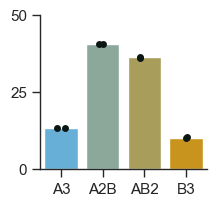

In [75]:
# Arg and LysArg without pSS:
c1 = 'C0'
c2 = 'C4'

gradient = gradientFader(c1, c2, n = 4)
fig, ax = plt.subplots(figsize = (2.15,2), dpi = 100)
sns.despine(fig, top = True, right = True)

sns.stripplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Arg'"), x = "variable", y = "value", color = "#0C1713")
sns.barplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Arg' "), x = "variable", y = "value", errorbar=None, palette=gradient)

ax.set(xlabel = "", ylabel = "", yticks = np.linspace(0, 50, 3))


/var/folders/tx/jcz7yt1s7tdg8h231t9g2zx40000gn/T/ipykernel_14022/2774831954.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Arg' "), x = "variable", y = "value", errorbar=None, palette=gradient)


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),

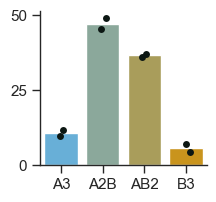

In [76]:
# Arg and LysArg with pSS:
c1 = 'C0'
c2 = 'C4'

gradient = gradientFader(c1, c2, n = 4)
fig, ax = plt.subplots(figsize = (2.15,2), dpi = 100)
sns.despine(fig, top = True, right = True)

sns.stripplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Arg'"), x = "variable", y = "value", color = "#0C1713")
sns.barplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Arg' "), x = "variable", y = "value", errorbar=None, palette=gradient)

ax.set(xlabel = "", ylabel = "", yticks = np.linspace(0, 50, 3))


/var/folders/tx/jcz7yt1s7tdg8h231t9g2zx40000gn/T/ipykernel_14022/1268840473.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Gly'"), x = "variable", y = "value", errorbar=None, palette=gradient)


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),

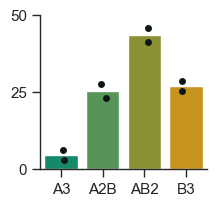

In [77]:
# Gly and LysArg with PSS
c1 = 'C1'
c2 = 'C4'

gradient = gradientFader(c1, c2, n = 4)
fig, ax = plt.subplots(figsize = (2.15,2), dpi = 100)
sns.despine(fig, top = True, right = True)

sns.stripplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Gly'"), x = "variable", y = "value", color = "#0C1713")
sns.barplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Gly'"), x = "variable", y = "value", errorbar=None, palette=gradient)

ax.set(xlabel = "", ylabel = "", yticks = np.linspace(0, 50, 3))


/var/folders/tx/jcz7yt1s7tdg8h231t9g2zx40000gn/T/ipykernel_14022/1909449567.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Gly'"), x = "variable", y = "value", errorbar=None, palette=gradient)


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),

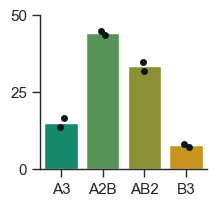

In [78]:
# Gly and LysArg without PSS
c1 = 'C1'
c2 = 'C4'

gradient = gradientFader(c1, c2, n = 4)
fig, ax = plt.subplots(figsize = (2.15,2), dpi = 100)
sns.despine(fig, top = True, right = True)

sns.stripplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Gly'"), x = "variable", y = "value", color = "#0C1713")
sns.barplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Gly'"), x = "variable", y = "value", errorbar=None, palette=gradient)

ax.set(xlabel = "", ylabel = "", yticks = np.linspace(0, 50, 3))


/var/folders/tx/jcz7yt1s7tdg8h231t9g2zx40000gn/T/ipykernel_14022/918566356.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Cys'"), x = "variable", y = "value", errorbar=None, palette=gradient)


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),

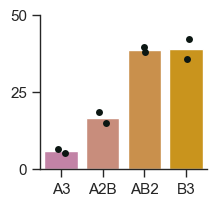

In [79]:
# Cys and LysArg with PSS
c1 = 'C2'
c2 = 'C4'

gradient = gradientFader(c1, c2, n = 4)
fig, ax = plt.subplots(figsize = (2.15,2), dpi = 100)
sns.despine(fig, top = True, right = True)

sns.stripplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Cys'"), x = "variable", y = "value", color = "#0C1713")
sns.barplot(data = df2.query("Type != 'no_pSS' & Azide1 == 'Cys'"), x = "variable", y = "value", errorbar=None, palette=gradient)

ax.set(xlabel = "", ylabel = "", yticks = np.linspace(0, 50, 3))


/var/folders/tx/jcz7yt1s7tdg8h231t9g2zx40000gn/T/ipykernel_14022/798066793.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Cys'"), x = "variable", y = "value", errorbar=None, palette=gradient)


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),

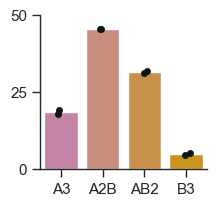

In [80]:
# Cys and LysArg without PSS
c1 = 'C2'
c2 = 'C4'

gradient = gradientFader(c1, c2, n = 4)
fig, ax = plt.subplots(figsize = (2.15,2), dpi = 100)
sns.despine(fig, top = True, right = True)

sns.stripplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Cys'"), x = "variable", y = "value", color = "#0C1713")
sns.barplot(data = df2.query("Type == 'no_pSS' & Azide1 == 'Cys'"), x = "variable", y = "value", errorbar=None, palette=gradient)

ax.set(xlabel = "", ylabel = "", yticks = np.linspace(0, 50, 3))


In [103]:
d = pd.read_csv("Final_Triazoles_Cys_Gly.csv")

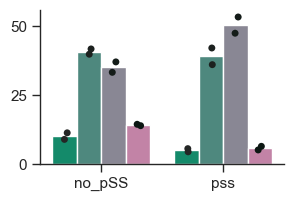

In [104]:
# Gly and Cys 

fig, ax = plt.subplots(figsize = (3.15,2), dpi = 100)
sns.despine(fig, top = True, right = True)

sns.stripplot(data = d, x = "Type", y = "value", palette='dark:#0C1713', hue = "variable", dodge=True, size = 5)

sns.barplot(data = d, x = "Type", y = "value", errorbar=None, hue = "variable", palette=gradientFader("C1", "C2", 4), width=.8)

ax.set(xlabel="", ylabel="", 
           yticks=np.linspace(0, 50, 3), 
           )
plt.legend([], frameon = False)
